In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
date = "20190809"
run_name = "08_13_2019_run_02"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [12]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[15:36:09 - __main__] Getting molbit sequences.
[15:36:09 - __main__] Locating fastq files.
[15:36:09 - __main__] Running SW, one fastq at a time.
[15:36:09 - __main__] Starting fastq (0 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_0.fastq


[########################################] | 100% Completed | 37.8s


[15:36:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_0.tsv
[15:36:47 - __main__] Starting fastq (1 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_1.fastq


[########################################] | 100% Completed | 52.2s


[15:37:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_1.tsv
[15:37:40 - __main__] Starting fastq (2 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_2.fastq


[########################################] | 100% Completed |  1min 14.9s


[15:38:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_2.tsv
[15:38:55 - __main__] Starting fastq (3 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_3.fastq


[########################################] | 100% Completed |  1min 18.1s


[15:40:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_0_3.tsv
[15:40:14 - __main__] Starting fastq (4 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_0.fastq


[########################################] | 100% Completed |  1min 33.4s


[15:41:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_0.tsv
[15:41:48 - __main__] Starting fastq (5 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_1.fastq


[########################################] | 100% Completed |  1min 22.3s


[15:43:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_1.tsv
[15:43:10 - __main__] Starting fastq (6 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_2.fastq


[########################################] | 100% Completed | 29.1s


[15:43:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_2.tsv
[15:43:40 - __main__] Starting fastq (7 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_3.fastq


[########################################] | 100% Completed | 46.8s


[15:44:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_1_3.tsv
[15:44:27 - __main__] Starting fastq (8 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_0.fastq


[########################################] | 100% Completed |  1min 13.2s


[15:45:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_0.tsv
[15:45:41 - __main__] Starting fastq (9 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_1.fastq


[########################################] | 100% Completed |  1min  0.8s


[15:46:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_1.tsv
[15:46:42 - __main__] Starting fastq (10 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_2.fastq


[########################################] | 100% Completed |  1min  0.1s


[15:47:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_2.tsv
[15:47:42 - __main__] Starting fastq (11 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_3.fastq


[########################################] | 100% Completed | 49.0s


[15:48:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_2_3.tsv
[15:48:32 - __main__] Starting fastq (12 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_0.fastq


[########################################] | 100% Completed |  1min  2.6s


[15:49:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_0.tsv
[15:49:35 - __main__] Starting fastq (13 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_1.fastq


[########################################] | 100% Completed |  1min  3.0s


[15:50:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_1.tsv
[15:50:38 - __main__] Starting fastq (14 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_2.fastq


[########################################] | 100% Completed | 25.5s


[15:51:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_2.tsv
[15:51:04 - __main__] Starting fastq (15 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_3.fastq


[########################################] | 100% Completed |  1min 24.4s


[15:52:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_3_3.tsv
[15:52:29 - __main__] Starting fastq (16 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_0.fastq


[########################################] | 100% Completed | 41.3s12.9s


[15:55:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_1.tsv
[15:55:05 - __main__] Starting fastq (18 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_2.fastq


[########################################] | 100% Completed | 58.8s


[15:56:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_2.tsv
[15:56:05 - __main__] Starting fastq (19 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_3.fastq


[########################################] | 100% Completed | 29.1s


[15:56:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_4_3.tsv
[15:56:34 - __main__] Starting fastq (20 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_0.fastq


[########################################] | 100% Completed | 35.0s


[15:57:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_0.tsv
[15:57:10 - __main__] Starting fastq (21 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_1.fastq


[########################################] | 100% Completed |  1min  6.8s


[15:58:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_1.tsv
[15:58:17 - __main__] Starting fastq (22 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_2.fastq


[########################################] | 100% Completed |  1min  6.6s


[15:59:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_2.tsv
[15:59:24 - __main__] Starting fastq (23 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_5_3.fastq


[#############################           ] | 72% Completed | 47.0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  2.3s


[16:09:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_0.tsv
[16:09:06 - __main__] Starting fastq (32 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_7_3.fastq


[########################################] | 100% Completed |  1.4s


[16:09:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_7_3.tsv
[16:09:08 - __main__] Starting fastq (33 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_1.fastq


[########################################] | 100% Completed |  1min 24.1s


[16:10:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_1.tsv
[16:10:33 - __main__] Starting fastq (34 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_2.fastq


[########################################] | 100% Completed |  1min 17.9s


[16:11:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_2.tsv
[16:11:51 - __main__] Starting fastq (35 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_9_0.fastq


[########################################] | 100% Completed |  1min 28.3s


[16:13:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_9_0.tsv
[16:13:20 - __main__] Starting fastq (36 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_3.fastq


[########################################] | 100% Completed | 10.5s


[16:13:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_8_3.tsv
[16:13:31 - __main__] Starting fastq (37 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_9_1.fastq


[###############                         ] | 39% Completed | 29.9s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  2min  3.7s


[16:25:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_0.tsv
[16:25:13 - __main__] Starting fastq (48 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_1.fastq


[########################################] | 100% Completed |  1min  9.3s


[16:26:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_1.tsv
[16:26:23 - __main__] Starting fastq (49 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_2.fastq


[########################################] | 100% Completed | 43.5s


[16:27:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_2.tsv
[16:27:07 - __main__] Starting fastq (50 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_11_3.fastq


[########################################] | 100% Completed | 33.4s


[16:27:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_11_3.tsv
[16:27:41 - __main__] Starting fastq (51 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_3.fastq


[########################################] | 100% Completed |  1.8s


[16:27:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_12_3.tsv
[16:27:43 - __main__] Starting fastq (52 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_13_0.fastq


[######################                  ] | 56% Completed |  1min 20.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 34.0s


[16:39:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_15_2.tsv
[16:39:15 - __main__] Starting fastq (63 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_16_0.fastq


[########################################] | 100% Completed |  1min 22.4s


[16:40:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_16_0.tsv
[16:40:38 - __main__] Starting fastq (64 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_16_1.fastq


[########################################] | 100% Completed |  1min 38.4s


[16:42:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_16_1.tsv
[16:42:17 - __main__] Starting fastq (65 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_15_3.fastq


[########################################] | 100% Completed | 53.6s


[16:43:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_15_3.tsv
[16:43:11 - __main__] Starting fastq (66 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_16_2.fastq


[###############                         ] | 38% Completed | 43.0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  2.1s


[16:53:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_0.tsv
[16:53:39 - __main__] Starting fastq (77 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_1.fastq


[########################################] | 100% Completed |  1min 14.5s


[16:54:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_1.tsv
[16:54:54 - __main__] Starting fastq (78 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_2.fastq


[########################################] | 100% Completed | 52.4s


[16:55:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_2.tsv
[16:55:47 - __main__] Starting fastq (79 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_3.fastq


[########################################] | 100% Completed |  1min  7.1s


[16:56:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_19_3.tsv
[16:56:55 - __main__] Starting fastq (80 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_20_0.fastq


[########################################] | 100% Completed | 50.1s


[16:57:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_20_0.tsv
[16:57:45 - __main__] Starting fastq (81 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_20_1.fastq


[#####################                   ] | 54% Completed | 57.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min 57.9s


[17:09:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_23_0.tsv
[17:09:49 - __main__] Starting fastq (91 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_22_2.fastq


[########################################] | 100% Completed |  1min 23.8s


[17:11:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_22_2.tsv
[17:11:13 - __main__] Starting fastq (92 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_22_3.fastq


[########################################] | 100% Completed |  2.2s


[17:11:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_22_3.tsv
[17:11:15 - __main__] Starting fastq (93 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_23_1.fastq


[########################################] | 100% Completed |  1min 50.8s


[17:13:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_23_1.tsv
[17:13:07 - __main__] Starting fastq (94 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_23_2.fastq


[########################################] | 100% Completed |  8.2s


[17:13:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_23_2.tsv
[17:13:15 - __main__] Starting fastq (95 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_24_0.fastq


[################################        ] | 81% Completed |  1min 23.8s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  2min  1.6s


[17:27:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_27_0.tsv
[17:27:26 - __main__] Starting fastq (108 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_27_1.fastq


[########################################] | 100% Completed |  1min 19.6s


[17:28:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_27_1.tsv
[17:28:46 - __main__] Starting fastq (109 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_26_3.fastq


[########################################] | 100% Completed |  2.0s


[17:28:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_26_3.tsv
[17:28:49 - __main__] Starting fastq (110 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_27_2.fastq


[########################################] | 100% Completed | 45.0s


[17:29:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_27_2.tsv
[17:29:34 - __main__] Starting fastq (111 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_28_0.fastq


[##############################          ] | 75% Completed |  1min  8.5s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  2.9s


[17:41:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_30_3.tsv
[17:41:30 - __main__] Starting fastq (124 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_0.fastq


[########################################] | 100% Completed |  1min 55.0s


[17:43:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_0.tsv
[17:43:25 - __main__] Starting fastq (125 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_1.fastq


[########################################] | 100% Completed |  1min  5.1s


[17:44:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_1.tsv
[17:44:31 - __main__] Starting fastq (126 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_2.fastq


[########################################] | 100% Completed | 34.7s


[17:45:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_2.tsv
[17:45:06 - __main__] Starting fastq (127 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_3.fastq


[########################################] | 100% Completed | 24.2s


[17:45:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_31_3.tsv
[17:45:30 - __main__] Starting fastq (128 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_32_0.fastq


[                                        ] | 0% Completed | 16.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  3min 30.3s


[17:57:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_34_1.tsv
[17:57:54 - __main__] Starting fastq (137 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_35_0.fastq


[########################################] | 100% Completed |  3min  2.1s


[18:00:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_35_0.tsv
[18:00:57 - __main__] Starting fastq (138 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_33_3.fastq


[########################################] | 100% Completed |  7.8s


[18:01:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_33_3.tsv
[18:01:05 - __main__] Starting fastq (139 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_34_2.fastq


[########################################] | 100% Completed |  4.1s


[18:01:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_34_2.tsv
[18:01:09 - __main__] Starting fastq (140 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_35_1.fastq


[###############                         ] | 38% Completed | 31.9s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 30.7s


[18:12:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_39_3.tsv
[18:12:30 - __main__] Starting fastq (160 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_0.fastq


[########################################] | 100% Completed | 38.3s


[18:13:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_0.tsv
[18:13:08 - __main__] Starting fastq (161 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_1.fastq


[########################################] | 100% Completed | 43.6s


[18:13:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_1.tsv
[18:13:52 - __main__] Starting fastq (162 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_2.fastq


[########################################] | 100% Completed | 37.3s


[18:14:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_2.tsv
[18:14:30 - __main__] Starting fastq (163 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_3.fastq


[########################################] | 100% Completed | 11.1s


[18:14:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_40_3.tsv
[18:14:41 - __main__] Starting fastq (164 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_0.fastq


[########################################] | 100% Completed | 34.3s


[18:15:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_0.tsv
[18:15:16 - __main__] Starting fastq (165 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_1.fastq


[########################################] | 100% Completed | 43.1s


[18:15:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_1.tsv
[18:15:59 - __main__] Starting fastq (166 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_2.fastq


[########################################] | 100% Completed | 11.7s


[18:16:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_2.tsv
[18:16:11 - __main__] Starting fastq (167 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_3.fastq


[########################################] | 100% Completed | 41.5s


[18:16:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_41_3.tsv
[18:16:53 - __main__] Starting fastq (168 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_42_0.fastq


[########################################] | 100% Completed | 24.8s


[18:17:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_42_0.tsv
[18:17:18 - __main__] Starting fastq (169 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_42_1.fastq


[                                        ] | 0% Completed | 14.8s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 45.3s


[18:28:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_0.tsv
[18:28:43 - __main__] Starting fastq (189 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_1.fastq


[########################################] | 100% Completed | 19.2s


[18:29:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_1.tsv
[18:29:03 - __main__] Starting fastq (190 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_2.fastq


[########################################] | 100% Completed | 10.6s


[18:29:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_2.tsv
[18:29:14 - __main__] Starting fastq (191 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_3.fastq


[########################################] | 100% Completed | 55.0s


[18:30:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_47_3.tsv
[18:30:09 - __main__] Starting fastq (192 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_0.fastq


[########################################] | 100% Completed | 49.8s


[18:30:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_0.tsv
[18:31:00 - __main__] Starting fastq (193 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_1.fastq


[########################################] | 100% Completed | 56.1s


[18:31:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_1.tsv
[18:31:56 - __main__] Starting fastq (194 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_2.fastq


[########################################] | 100% Completed | 22.5s


[18:32:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_48_2.tsv
[18:32:19 - __main__] Starting fastq (195 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_49_0.fastq


[########################################] | 100% Completed | 40.9s


[18:33:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_49_0.tsv
[18:33:00 - __main__] Starting fastq (196 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_49_1.fastq


[########################################] | 100% Completed | 12.1s


[18:33:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_49_1.tsv
[18:33:13 - __main__] Starting fastq (197 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_49_2.fastq


[####                                    ] | 12% Completed | 17.3s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  0.1s


[18:44:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_0.tsv
[18:44:36 - __main__] Starting fastq (217 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_1.fastq


[########################################] | 100% Completed | 26.5s


[18:45:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_1.tsv
[18:45:03 - __main__] Starting fastq (218 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_2.fastq


[########################################] | 100% Completed | 25.0s


[18:45:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_2.tsv
[18:45:28 - __main__] Starting fastq (219 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_3.fastq


[########################################] | 100% Completed | 18.5s


[18:45:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_54_3.tsv
[18:45:47 - __main__] Starting fastq (220 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_0.fastq


[########################################] | 100% Completed | 41.4s


[18:46:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_0.tsv
[18:46:28 - __main__] Starting fastq (221 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_1.fastq


[########################################] | 100% Completed | 23.8s


[18:46:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_1.tsv
[18:46:53 - __main__] Starting fastq (222 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_2.fastq


[########################################] | 100% Completed | 29.7s


[18:47:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_2.tsv
[18:47:23 - __main__] Starting fastq (223 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_3.fastq


[########################################] | 100% Completed | 15.5s


[18:47:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_55_3.tsv
[18:47:38 - __main__] Starting fastq (224 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_0.fastq


[########################################] | 100% Completed | 47.9s


[18:48:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_0.tsv
[18:48:27 - __main__] Starting fastq (225 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_1.fastq


[########################################] | 100% Completed | 36.1s


[18:49:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_1.tsv
[18:49:03 - __main__] Starting fastq (226 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_2.fastq


[########################################] | 100% Completed | 18.7s


[18:49:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_2.tsv
[18:49:22 - __main__] Starting fastq (227 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_56_3.fastq


[                                        ] | 0% Completed |  4.1s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 37.5s


[19:00:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_61_1.tsv
[19:00:23 - __main__] Starting fastq (246 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_61_2.fastq


[########################################] | 100% Completed | 24.2s


[19:00:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_61_2.tsv
[19:00:47 - __main__] Starting fastq (247 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_61_3.fastq


[########################################] | 100% Completed | 11.7s


[19:00:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_61_3.tsv
[19:00:59 - __main__] Starting fastq (248 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_0.fastq


[########################################] | 100% Completed | 53.1s


[19:01:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_0.tsv
[19:01:53 - __main__] Starting fastq (249 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_1.fastq


[########################################] | 100% Completed | 34.2s


[19:02:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_1.tsv
[19:02:27 - __main__] Starting fastq (250 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_2.fastq


[########################################] | 100% Completed | 21.4s


[19:02:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_2.tsv
[19:02:49 - __main__] Starting fastq (251 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_3.fastq


[########################################] | 100% Completed | 20.8s


[19:03:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_62_3.tsv
[19:03:10 - __main__] Starting fastq (252 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_0.fastq


[########################################] | 100% Completed |  0.8s


[19:03:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_0.tsv
[19:03:11 - __main__] Starting fastq (253 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_63_0.fastq


[########################################] | 100% Completed |  0.8s


[19:03:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_63_0.tsv
[19:03:12 - __main__] Starting fastq (254 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_1.fastq


[########################################] | 100% Completed |  0.9s


[19:03:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_1.tsv
[19:03:14 - __main__] Starting fastq (255 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_2.fastq


[########################################] | 100% Completed |  1.0s


[19:03:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_2.tsv
[19:03:15 - __main__] Starting fastq (256 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_65_0.fastq


[########################################] | 100% Completed | 56.6s


[19:04:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_65_0.tsv
[19:04:12 - __main__] Starting fastq (257 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_65_1.fastq


[########################################] | 100% Completed | 37.4s


[19:04:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_65_1.tsv
[19:04:50 - __main__] Starting fastq (258 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_3.fastq


[########################################] | 100% Completed |  0.9s


[19:04:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_64_3.tsv
[19:04:51 - __main__] Starting fastq (259 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_65_2.fastq


[#################                       ] | 42% Completed | 22.5s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  2.0s


[19:16:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_0.tsv
[19:16:47 - __main__] Starting fastq (280 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_1.fastq


[########################################] | 100% Completed | 35.4s


[19:17:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_1.tsv
[19:17:23 - __main__] Starting fastq (281 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_2.fastq


[########################################] | 100% Completed |  7.7s


[19:17:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_2.tsv
[19:17:31 - __main__] Starting fastq (282 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_3.fastq


[########################################] | 100% Completed | 38.3s


[19:18:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_71_3.tsv
[19:18:10 - __main__] Starting fastq (283 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_0.fastq


[########################################] | 100% Completed | 25.0s


[19:18:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_0.tsv
[19:18:35 - __main__] Starting fastq (284 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_1.fastq


[########################################] | 100% Completed |  1min 12.4s


[19:19:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_1.tsv
[19:19:48 - __main__] Starting fastq (285 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_2.fastq


[########################################] | 100% Completed |  3.9s


[19:19:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_2.tsv
[19:19:52 - __main__] Starting fastq (286 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_3.fastq


[########################################] | 100% Completed | 43.7s


[19:20:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_72_3.tsv
[19:20:36 - __main__] Starting fastq (287 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_73_0.fastq


[################                        ] | 41% Completed | 34.3s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 31.0s


[19:32:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_77_2.tsv
[19:32:24 - __main__] Starting fastq (306 of 307)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/pass/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_77_3.fastq


[########################################] | 100% Completed | 23.3s


[19:32:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/fastq_runid_cbeb224beba4132d960067800238defaeed962bf_77_3.tsv


In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[19:32:52 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[19:32:52 - matplotlib.fo

[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[19:32:52 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[19:32:52 - matplotlib.font_manager] 

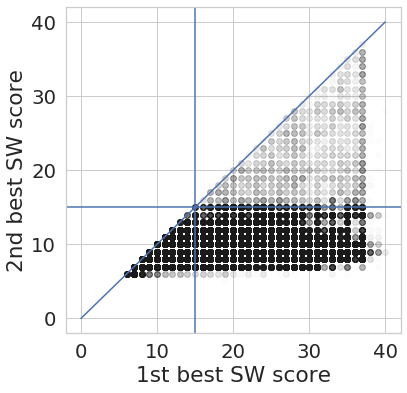

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

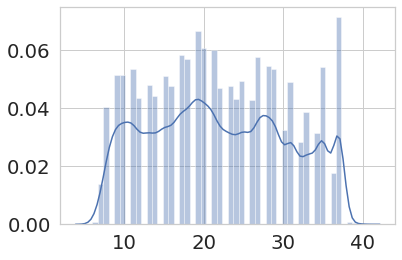

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_02_exec_20190813/sw/all_cbeb224beba4132d960067800238defaeed962bf.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [75]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [76]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

0
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
['16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [77]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [78]:
sum(accept_molbit) / len(accept_molbit)

0.7637102073453619

## Extract the best-aligned molbit, across ONLY the extant molbits

In [98]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [99]:
extant_sw = sw.loc[:, extant_sw_cols]

In [100]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [101]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [102]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [103]:
n_extant_is_best

192799

Percentage of well-aligned reads that belong to the true set

In [104]:
n_extant_is_best/len(sw_accepted)

0.9993209972528897

Read counts for each molbit

In [105]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 40),
 ('1', 35),
 ('10', 21),
 ('11', 70),
 ('12', 177),
 ('13', 37),
 ('14', 60),
 ('15', 170),
 ('16', 22817),
 ('17', 7931),
 ('18', 11506),
 ('19', 24394),
 ('2', 99),
 ('20', 19096),
 ('21', 8626),
 ('22', 6989),
 ('23', 2203),
 ('24', 3687),
 ('25', 11527),
 ('26', 12905),
 ('27', 9212),
 ('28', 5322),
 ('29', 15438),
 ('3', 184),
 ('30', 14727),
 ('31', 15019),
 ('4', 68),
 ('5', 123),
 ('6', 148),
 ('7', 78),
 ('8', 92),
 ('9', 129)]

## Extract the best-aligned molbit, across ONLY the current run's molbits

In [87]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [88]:
extant_sw = sw.loc[:, extant_sw_cols]

In [89]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [90]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [91]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [92]:
n_extant_is_best

191278

Percentage of well-aligned reads that belong to the true set

In [93]:
n_extant_is_best/len(sw_accepted)

0.9914373088685016

Read counts for each molbit

In [94]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('16', 22922),
 ('17', 8138),
 ('18', 11588),
 ('19', 24652),
 ('20', 19277),
 ('21', 8655),
 ('22', 7023),
 ('23', 2214),
 ('24', 3718),
 ('25', 11597),
 ('26', 12942),
 ('27', 9406),
 ('28', 5371),
 ('29', 15477),
 ('30', 14886),
 ('31', 15064)]

## Get counts for all molbits

In [106]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

40
35
99
184
68
122
147
77
91
127
20
70
178
38
59
170
22810
7880
11500
24389
19092
8624
6988
2196
3681
11522
12896
9207
5322
15432
14720
15019
0
0
0
0
3
1
0
0
0
0
4
2
0
0
0
0
3
0
0
0
0
1
0
5
1
0
0
2
1
49
1
0
2
1
0
0
1
3
0
0
6
7
0
0
0
3
1
0
0
0
0
0
5
6
0
2
1
7
0
1
0
4
1
3
